# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignment page](https://bcourses.berkeley.edu/courses/1453965/assignments/7738616) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs294_129.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs294_129.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs294_129/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs294_129.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs294_129.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 2e-9, 3e-9, 4e-9, 5e-9]
regularization_strengths = [1e6, 2e6, 3e6, 4e6, 5e6]

results = {}
best_val = -1
best_svm = None


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs,
            num_iters=5000,batch_size =100, verbose=False)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        accuracy_train = np.mean(y_train == y_train_pred)
        accuracy_val = np.mean(y_val == y_val_pred)
        
        results[(lr, rs)] = (accuracy_train, accuracy_val)
        
        # store best validation accuracy and best svm model 
        if best_val < accuracy_val:
            best_val = accuracy_val
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 1.000000e-09 reg 1.000000e+06 train accuracy: 0.126224 val accuracy: 0.130000
lr 1.000000e-09 reg 2.000000e+06 train accuracy: 0.404041 val accuracy: 0.403000
lr 1.000000e-09 reg 3.000000e+06 train accuracy: 0.416429 val accuracy: 0.416000
lr 1.000000e-09 reg 4.000000e+06 train accuracy: 0.412204 val accuracy: 0.417000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.412980 val accuracy: 0.405000
lr 2.000000e-09 reg 1.000000e+06 train accuracy: 0.413551 val accuracy: 0.417000
lr 2.000000e-09 reg 2.000000e+06 train accuracy: 0.417612 val accuracy: 0.421000
lr 2.000000e-09 reg 3.000000e+06 train accuracy: 0.413531 val accuracy: 0.410000
lr 2.000000e-09 reg 4.000000e+06 train accuracy: 0.412204 val accuracy: 0.403000
lr 2.000000e-09 reg 5.000000e+06 train accuracy: 0.408755 val accuracy: 0.405000
lr 3.000000e-09 reg 1.000000e+06 train accuracy: 0.413000 val accuracy: 0.416000
lr 3.000000e-09 reg 2.000000e+06 train accuracy: 0.413286 val accuracy: 0.406000
lr 3.000000e-09 reg 3.000000

In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.418


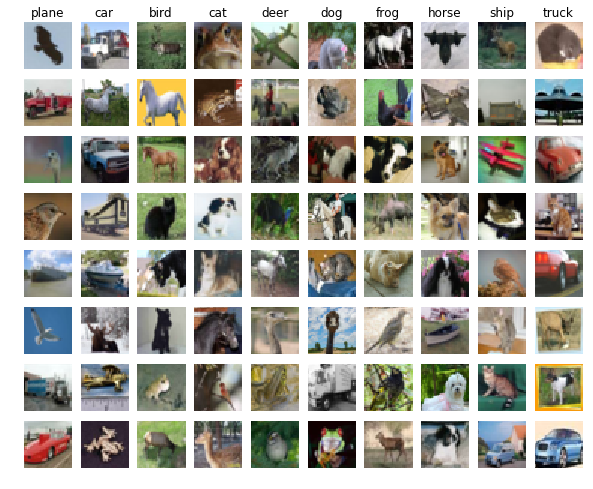

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:

Describe the misclassification results that you see. Do they make sense?

#### Answer:

The results make sense since we use HOG and histogram of colors as features. The color histograms will make the classifier lable images with similar backgrounds as the same class. For instance, most of the wrongly classified images in class plain has blue background. For the HOG features, they describe the shape. For car and truck, or cat,horse and dog, they has simmilar shapes. Thus the classifier could not tell the difference. 

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
print X_train_feats.shape

(49000, 155)


In [8]:
from cs294_129.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
learning_rates = [1, 7e-1]
#regs = [0.8, 0.9, 1]
regs = [1e-3, 1e-4]
#hidden_sizes = [2500,3500, 4500]
hidden_sizes = [1000, 1300]
num_classes = 10
best_val = -1
best_hyper=()
for lr in learning_rates:
    for rg in regs:
        for hidden_size in hidden_sizes:
            net = TwoLayerNet(input_dim, hidden_size, num_classes)
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=5000, batch_size=500,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=rg, verbose=False)
            # Predict on the validation set
            train_acc = (net.predict(X_train_feats) == y_train).mean()
            val_acc = (net.predict(X_val_feats) == y_val).mean()
            print "lr: %e, reg: %e, hidden size: %f, training accuracy: %f, validation accuracy: %f" % (
                lr, rg, hidden_size, train_acc, val_acc )
            # store best validation accuracy and best svm model 
            if best_val < val_acc:
                best_val = val_acc
                best_net = net
                best_hyper = (lr, rg, hidden_size)
net = best_net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr: 1.000000e+00, reg: 1.000000e-03, hidden size: 1000.000000, training accuracy: 0.924184, validation accuracy: 0.605000
lr: 1.000000e+00, reg: 1.000000e-03, hidden size: 1300.000000, training accuracy: 0.931755, validation accuracy: 0.598000
lr: 1.000000e+00, reg: 1.000000e-04, hidden size: 1000.000000, training accuracy: 0.983286, validation accuracy: 0.589000
lr: 1.000000e+00, reg: 1.000000e-04, hidden size: 1300.000000, training accuracy: 0.987163, validation accuracy: 0.597000
lr: 7.000000e-01, reg: 1.000000e-03, hidden size: 1000.000000, training accuracy: 0.872265, validation accuracy: 0.610000
lr: 7.000000e-01, reg: 1.000000e-03, hidden size: 1300.000000, training accuracy: 0.882490, validation accuracy: 0.612000
lr: 7.000000e-01, reg: 1.000000e-04, hidden size: 1000.000000, training accuracy: 0.935449, validation accuracy: 0.604000
lr: 7.000000e-01, reg: 1.000000e-04, hidden size: 1300.000000, training accuracy: 0.942245, validation accuracy: 0.599000


In [9]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print test_acc

0.611


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

### Adding statistic features of images
Statistic features, including mean of each channel, median of each channel, and the covariance matrix across channels are added. By adding these features, we can achieve slightly better performance (about 2% in my experienments) on the best neural network model.

In [10]:
from cs294_129.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins), stat_features]
X_train_feats_new = extract_features(X_train, feature_fns, verbose=True)
X_val_feats_new = extract_features(X_val, feature_fns)
X_test_feats_new = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats_new, axis=0, keepdims=True)
X_train_feats_new -= mean_feat
X_val_feats_new -= mean_feat
X_test_feats_new -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats_new, axis=0, keepdims=True)
X_train_feats_new /= std_feat
X_val_feats_new /= std_feat
X_test_feats_new /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats_new = np.hstack([X_train_feats_new, np.ones((X_train_feats_new.shape[0], 1))])
X_val_feats_new = np.hstack([X_val_feats_new, np.ones((X_val_feats_new.shape[0], 1))])
X_test_feats_new = np.hstack([X_test_feats_new, np.ones((X_test_feats_new.shape[0], 1))])

print X_train_feats_new.shape

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [11]:
from cs294_129.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats_new.shape[1]
print input_dim
hidden_dim = 500
num_classes = 10
net = None
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
learning_rates = [1, 7e-1]
#regs = [0.8, 0.9, 1]
regs = [1e-3, 1e-4]
#hidden_sizes = [2500,3500, 4500]
hidden_sizes = [1000, 1300]
num_classes = 10
best_val = -1
best_hyper=()
for lr in learning_rates:
    for rg in regs:
        for hidden_size in hidden_sizes:
            net = TwoLayerNet(input_dim, hidden_size, num_classes)
            stats = net.train(X_train_feats_new, y_train, X_val_feats_new, y_val,
                num_iters=5000, batch_size=500,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=rg, verbose=False)
            # Predict on the validation set
            train_acc = (net.predict(X_train_feats_new) == y_train).mean()
            val_acc = (net.predict(X_val_feats_new) == y_val).mean()
            print "lr: %e, reg: %e, hidden size: %f, training accuracy: %f, validation accuracy: %f" % (
                lr, rg, hidden_size, train_acc, val_acc )
            # store best validation accuracy and best svm model 
            if best_val < val_acc:
                best_val = val_acc
                best_net = net
                best_hyper = (lr, rg, hidden_size)
net = best_net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################


170
lr: 1.000000e+00, reg: 1.000000e-03, hidden size: 1000.000000, training accuracy: 0.936245, validation accuracy: 0.635000
lr: 1.000000e+00, reg: 1.000000e-03, hidden size: 1300.000000, training accuracy: 0.943653, validation accuracy: 0.622000
lr: 1.000000e+00, reg: 1.000000e-04, hidden size: 1000.000000, training accuracy: 0.988857, validation accuracy: 0.634000
lr: 1.000000e+00, reg: 1.000000e-04, hidden size: 1300.000000, training accuracy: 0.991571, validation accuracy: 0.610000
lr: 7.000000e-01, reg: 1.000000e-03, hidden size: 1000.000000, training accuracy: 0.891408, validation accuracy: 0.633000
lr: 7.000000e-01, reg: 1.000000e-03, hidden size: 1300.000000, training accuracy: 0.898633, validation accuracy: 0.627000
lr: 7.000000e-01, reg: 1.000000e-04, hidden size: 1000.000000, training accuracy: 0.947837, validation accuracy: 0.617000
lr: 7.000000e-01, reg: 1.000000e-04, hidden size: 1300.000000, training accuracy: 0.956857, validation accuracy: 0.619000


In [12]:
# Evaluate your trained nn on the test set
y_test_pred = best_net.predict(X_test_feats_new)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.624


# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!

## Using t-SNE to Visualize the Data
This part of code uses t-SNE to reduce the dimension 

In [13]:

from sklearn.manifold import TSNE
num_test = X_test_feats.shape[0]
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
model = TSNE(n_components=2, random_state=0)
X_2d = model.fit_transform(X_test_feats)


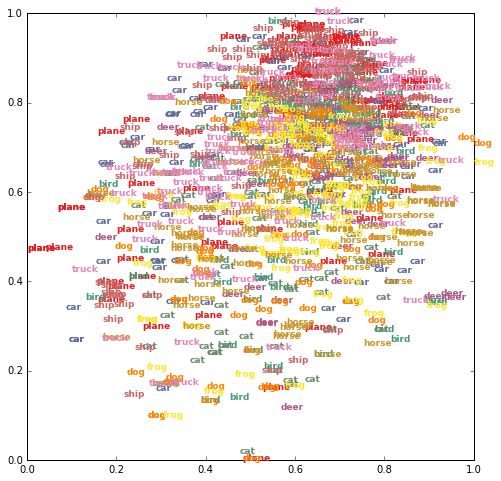

In [14]:
examples_per_class = 100
x_min, x_max = np.min(X_2d, 0), np.max(X_2d, 0)
X_2d = (X_2d - x_min) / (x_max - x_min)

plt.figure(figsize=(8,8))

for  cls, cls_name in enumerate(classes):
    indxs = np.where(y_test == cls)[0]
    #indxs = np.random.choice(indxs, examples_per_class, replace=False)
    X_plot = X_2d[indxs, :]
    y = y_test[indxs]
    for i in range(X_plot.shape[0]):
        plt.text(X_plot[i, 0], X_plot[i, 1], cls_name,
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

### Activation of the second layer of the best neural network
Let's check whether he images are more linear separable after the second layer of the neural network.

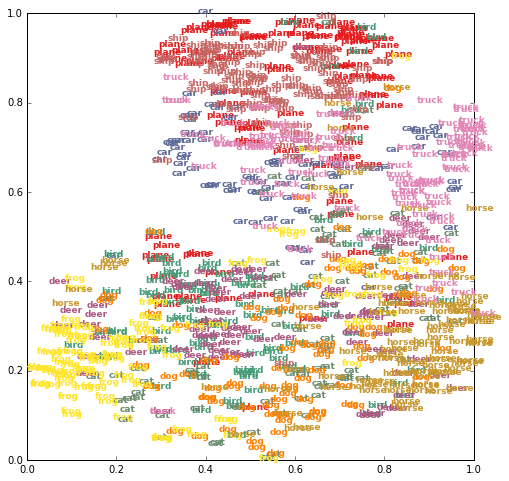

In [15]:
extracted_feats = best_net.extracted_features(X_test_feats_new)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
model = TSNE(n_components=2, random_state=0)
X_2d_ect = model.fit_transform(extracted_feats)

examples_per_class = 100
x_min, x_max = np.min(X_2d_ect , 0), np.max(X_2d_ect , 0)
X_2d_ect = (X_2d_ect  - x_min) / (x_max - x_min)

plt.figure(figsize=(8,8))

for  cls, cls_name in enumerate(classes):
    indxs = np.where(y_test == cls)[0]
    #indxs = np.random.choice(indxs, examples_per_class, replace=False)
    X_plot = X_2d_ect[indxs, :]
    y = y_test[indxs]
    for i in range(X_plot.shape[0]):
        plt.text(X_plot[i, 0], X_plot[i, 1], cls_name,
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

### Score of SVM
We can also plot the score of SVM using TSNE to reduce the dimension.

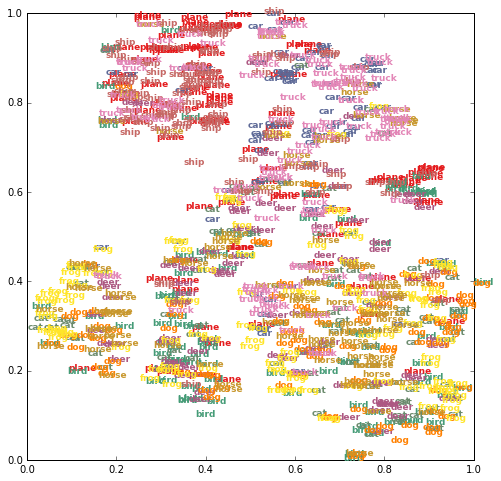

In [16]:
extracted_feats = best_svm.extract_score(X_test_feats)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
model = TSNE(n_components=2, random_state=0)
X_2d_ect = model.fit_transform(extracted_feats)

examples_per_class = 100
x_min, x_max = np.min(X_2d_ect , 0), np.max(X_2d_ect , 0)
X_2d_ect = (X_2d_ect  - x_min) / (x_max - x_min)

plt.figure(figsize=(8,8))

for  cls, cls_name in enumerate(classes):
    indxs = np.where(y_test == cls)[0]
    #indxs = np.random.choice(indxs, examples_per_class, replace=False)
    X_plot = X_2d_ect[indxs, :]
    y = y_test[indxs]
    for i in range(X_plot.shape[0]):
        plt.text(X_plot[i, 0], X_plot[i, 1], cls_name,
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

Comparing the data after dimension reduction, the two-layer neural network transforms the data such that the points of different classes are the easist to separate. This explains why the two-layer neural network performs best.  